In [1]:
import os
import sys
sys.path.append(os.path.abspath('repo/rnn/'))


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import math
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.interpolate import BSpline
from IPython.display import display, Markdown, Latex
import re
import copy
import inspect

In [3]:
p = torch.tensor([[1, 2, 3, 4, 5], [10, 20, 30, 40, 50]]).float()
lin = nn.Linear(5, 3)
p = lin(p)
p = p.sum(0).sum(0)

In [4]:
def all_offr_codes(offr_code):
    '''
    Description: Generates a list of offer codes for all offers
    preceeding the offer given by 'offr_code', including that
    offer itself
    Input: String denoting last offer code to be generated
    Returns: list of strings
    '''
    out = []
    # check correct format of offr_code
    if len(offr_code) != 2:
        raise ValueError('offr code should have length 2')
    #  extract turn type and num
    turn_num = int(offr_code[1])
    turn_type = offr_code[0]
    # iterate to (inclusive) turn_num
    for i in range(turn_num + 1):
        # add all buyer turns up to and including the current turn
        # to the list
        out.append('b%d' % i)
        # do not add the seller turn for the last round if
        # the last turn is a buyer turn
        if i < turn_num or turn_type == 's':
            out.append('s%d' % i)
    return out


In [5]:
from models import *

In [41]:
print(inspect.getsource(increase_num_layers))

def increase_num_layers(const_vals, num_layers, zeros=True):
    # this gives the total number of layers of rnns
    # adjust to give layers of starting values that must be added
    # since the constant features ( or 0's, should already occupy first layer)
    num_add = num_layers - 1
    # grab sizes of other dimensions
    batch = const_vals.shape[1]
    hidden_size = const_vals.shape[2]
    # iterate over values through num, add a layer of 0's for each
    for _ in range(num_add):
        if zeros:
            # initialize empty array to add
            empty_arr = np.zeros((1, batch, hidden_size))
            # append along the first axis
        else:
            empty_arr = np.expand_dims(const_vals[0, :, :], axis=0)
        const_vals = np.append(const_vals, empty_arr, axis=0)
    return const_vals



In [6]:
def get_all_exps(base_str):
    layers = ['_layr3', '_layr2', '']
    hiddens = ['_hidn75', '_hidn100', '']
    init = ['_init', '']
    val = ['_val', '']
    arch = ['_cat', '_simp']
    zeros = ['_zeros', '']
    exps = []
    for curr_arch in arch:
        for curr_layer in layers:
            for curr_hidden in hiddens:
                for curr_init in init:
                    for curr_zero in zeros:
                        for curr_val in val:
                            curr_exp = '%s%s%s%s%s%s%s' % (base_str, curr_arch, curr_layer,
                                                           curr_hidden, curr_init, curr_zero, curr_val)
                            exps.append(curr_exp)
    return exps


In [7]:
# parameters for experiments displayed
# data types
# to be changed later
experiments = get_all_exps('rnn2')


In [8]:
def get_data_name(exp_name):
    if 'lstm' in exp_name:
        data_name = exp_name.replace('lstm', 'rnn')
    else:
        data_name = exp_name
    arch_type_str = r'_(simp|cat|sep)'
    type_match = re.search(arch_type_str, exp_name)
    if type_match is None:
        raise ValueError('Invalid experiment name')
    type_match_end = type_match.span(0)[1]
    data_name = data_name[:type_match_end]
    return data_name


In [9]:
def get_resp_offr(turn):
    '''
    Description: Determines the name of the response column given the name of the last observed turn
    '''
    turn_num = turn[1]
    turn_type = turn[0]
    if turn != 'start_price_usd':
        turn_num = int(turn_num)
    if turn_type == 'b':
        resp_turn = 's' + str(turn_num)
    elif turn == 'start_price_usd':
        resp_turn = 'b0'
    elif turn_type == 's':
        resp_turn = 'b' + str(turn_num + 1)
    resp_col = 'offr_' + resp_turn
    return resp_col

In [10]:
def get_resp_time(turn):
    '''
    Description: Determines the name of the response column given the 
    name of the last observed turn
    for time models
    '''
    turn_num = turn[1]
    turn_type = turn[0]
    turn_num = int(turn_num)
    if turn_type == 'b':
        resp_turn = 's' + str(turn_num)
    elif turn == 'start_price_usd':
        resp_turn = None
    elif turn_type == 's':
        resp_turn = 'b' + str(turn_num + 1)
    resp_col = 'time_%s' % resp_turn
    return resp_col

In [11]:
def get_prev_code(turn):
    '''
    Description: get the column name of the previous turn made 
    by the player for whom we're predicting the next
    turn. If the current turn we're predicting is the seller's
    first turn, return 'start_price_usd'. If the current 
    turn we're predicting is the buyer's first turn,  
    '''
    if turn == 'start_price_usd':
        prev_turn = ''
        return prev_turn
    turn_num = int(turn[1])
    turn_type = turn[0]
    if turn_type == 's':
        prev_turn = 'b' + str(turn_num)
    elif turn_type == 'b':
        if turn_num == 0:
            prev_turn = 'start_price_usd'
        else:
            prev_turn = 's' + str(turn_num - 1)
    return prev_turn

In [12]:
def get_feat_desc(exp_name):
    '''
    Description: Parses the name of the experiment to extract information about the features used in the model
    '''
    data_type = re.findall(r'\d+', exp_name)[0]
    data_type = int(data_type)
    if 'norm' not in exp_name:
        if data_type % 2 == 0:
            return 'Only offer history and starting price included as features. Training stopped after drawing' + \
            'minibatches (with replacement) equivalent to 20 times the size of the data.'
        else:
            return 'Offer history, buyer feedback scores, fraction of auction remaining at time of offer,' + \
            ' time (in hours) each player took to make hitherto observed offers, number of previous threads ' + \
            'buyer and seller have engaged in, indicators for item category, and quality. Training stopped after' + \
            'drawing minibatches (with replacement) equivalent to 5 times the size of the data'
    else:
        if data_type == 1:
            return 'Offer history normalized by difference between two most recent offers; no date or time features;' + \
            'number of previous threads and other experience features, rounding and slack features for 1, 5, 10, 25;' + \
            'indicators for item category and quality'
        elif data_type == 2:
            return 'Offer history normalized by difference between two most recent offers; fraction of time remaining,' + \
            'time to make offer for each offer, indicators for whether each offer was made in the morning, evening, night,' + \
            'or afternoon (1 excluded), and the time of day in hours for each observed offer,' + \
            'number of previous threads and other experience features, rounding and slack features for 1, 5, 10, 25;' + \
            'indicators for item category and quality'
def get_bin_desc(exp_name):
    if 'norm' not in exp_name:
        data_type = int(exp_name[len(exp_name) - 1])
        if data_type <= 2:
            return 'Offer values rounded to every even 50 cent [3, 1000] in symmetric 25 cent window around each ' + \
            'rounding target'
        else:
            return 'Offer values rounded to 1% of most common values observed for offer being predicted provided ' + \
            'that the center of each bin is at least 50 cents from the center of adjacent bins -- this requirement ' + \
            'reduces the number of bins to approximately 170 from about 500'
    else:
        data_type = int(re.findall(r'\d+', exp_name)[0])
        if data_type == 1 or data_type == 2:
            return 'Normalized offer values binned at every hundredth between 0 and 1'
def get_arc_desc(exp_name):
    if 'cross' in exp_name:
        return 'Standard multi-class prediction arcitecture, outputting scores over all possible bins, trained ' + \
        'using cross entropy loss, predicts the center of the bin with the highest score'
    else:
        return 'Hidden softmax layer after final non-linear activation layer constructs a distribution over bins ' + \
        'then output layer predicts the expectation of this distribution. Trained using squared loss.'
def get_comp_desc(exp_name):
    if 'simp' in exp_name:
        return '1 non-linear activation layer containing 30 units'
    else:
        return '2 non-linear activation layers containing 100 units'

In [13]:
def check_done(exp_name):
    '''
    Description: Checks whether an experiment is complete
    '''
    return os.path.isfile('data/exps/%s/model.pth.tar' % (exp_name))

In [14]:
def pandas_df_to_markdown_table(df):
    '''
    Description: converts pandas data frame to markdown table
    '''
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    display(Markdown(df_formatted.to_csv(sep="|", index=False)))

In [15]:
def get_prep_type(data_name):
    arch_type = r'_(simp|cat|sep)'
    arch_match = re.search(arch_type, data_name)
    start_arch = arch_match.span(0)[0]
    prep_type = data_name[:start_arch]
    return prep_type

In [16]:
def unpickle(path):
    '''
    Extracts an abritrary object from the pickle located at path and returns
    that object

    Args:
        path: string denoting path to pickle

    Returns:
        arbitrary object contained in pickle
    '''
    f = open(path, "rb")
    obj = pickle.load(f)
    f.close()
    return obj

In [17]:
def get_resp_list(data_name):
    '''
    Parses the name of the data used to train the model to extract an ordered list of the columns represented by the output of each step
    '''
    resp = []
    resp = all_offr_codes('s2')
    resp.remove('b0')
    if 'simp' in data_name:
        if 'b3' in data_name:
            resp.append('b3')
    elif 'sep' in data_name or 'cat' in data_name:
        resp = [code for code in resp if 's' in code]
    else:
        raise ValueError('Cannot parse response list from experiment name')
    # print('resp list')
    # print(resp)
    return resp
        
        

In [18]:
def add_start_price(test_ref, norm_df, const_feats, const_vals):
    curr_mean = norm_df.at['start_price_usd', 'mean']
    curr_std = norm_df.at['start_price_usd', 'std']
    ind = const_feats.index('start_price_usd')
    ref_start_price = const_vals[:, :, ind] * curr_std + curr_mean
    ref_start_price = np.squeeze(ref_start_price)
    if len(ref_start_price.shape)!= 1:
        raise ValueError('Unrolling problem')
    if ref_start_price.size != len(test_ref.index):
        raise ValueError('Unrolling problem')
    test_ref['ref_start_price_usd'] = pd.Series(ref_start_price, index=test_ref.index)
    return test_ref
    

In [19]:
def make_loss_wrapper(criterion=None):
    def loss_funct(pred, truth):
        if criterion is not None:
            curr_loss = criterion(pred.double(), truth.double())
            curr_loss = curr_loss.detach().numpy()
            curr_loss = np.nanmean(curr_loss, axis = 1)
            return curr_loss
        else:
            pred = pred.numpy()
            truth = truth.numpy()
            curr_loss = np.square(pred - truth)
            curr_loss = np.nanmean(curr_loss, axis = 1)
            return curr_loss
    return loss_funct

In [20]:
def get_exp_data(exp_name, offr_mod):
    '''
    Description: Loads all necessary test data and model specification files (bins, loss history, 
    feature dictionary, class series) and computes model predictions...Stores all data and predictions used later
    in an output dictionary
    '''
    # data type
    data_name = get_data_name(exp_name)
    # print('data name: %s' % data_name)
    prep_type = get_prep_type(data_name)
    
    response_list = get_resp_list(data_name)
    # loss history
    loss_dict = unpickle('data/exps/%s/loss.pickle' % exp_name)
    train_loss = loss_dict['train_loss']

    # if a validation set was used, grab the validation set loss too
    if 'val' in exp_name:
        valid_loss = loss_dict['valid_loss']

    if len(train_loss) > 0:
        if not isinstance(train_loss[0], torch.FloatTensor):
            train_loss = train_loss[1:]
    
    # feature dictionary
    feat_dict = unpickle('data/exps/%s/feats.pickle' % data_name)

    # NOTE: deprecate?
    # reverse = {}
    # for col, ind in feat_dict.items():
    #    reverse[ind] = col

    # column list...no idea why I used a dictionary for this tbh
    # col_list = []
    # for i in range(len(reverse)):
    #     next_col = reverse[i]
    #     col_list.append(next_col)

    # normalization attributes
    norm_df = pd.read_csv('data/exps/%s/norm.csv' % prep_type)
    
    norm_df.set_index('cols', drop=True, inplace=True)                      
    # load bins and midpoints
    if offr_mod:
        with open('data/exps/%s/bins.pickle' % prep_type, 'rb') as f:
            bin_dict = pickle.load(f)
        f.close()
        midpoints = bin_dict['midpoints']
        bins = bin_dict['bins']
    else:
        with open('data/exps/%s/time_bins.pickle' % prep_type, 'rb') as f:
            bin_dict = pickle.load(f)
        f.close()
        midpoints = bin_dict['time_midpoints']
        bins = bin_dict['time_bins']
    
    # load model parameters
    model_dict = torch.load('data/exps/%s/model.pth.tar' % exp_name)
                          
    
    # normalized test data for use in model
    # load test data
    test_data = unpickle('data/exps/%s/test_data.pickle' % data_name)
                          
    #############
    # TEMPORARY FIX WHILE THIS PROBLEM REMAINS WITH THIS SUBSET OF DATA
    ##############
    
    test_ref = test_data['ref_vals']
    #################################################################
    # TEMPORARY FIX WHILE THIS PROBLEM REMAINS WITH THIS SUBSET OF DATA
    # add start price usd to ref_df
    # test_ref = add_start_price(test_ref, norm_df, feat_dict['const_feats'], test_data['const_vals'])
    # print(test_ref['ref_start_price_usd'].mean())
    # extract elements from data_dict
    
    test_offr_vals = test_data['offr_vals']
    test_const_vals = test_data['const_vals']
    test_targ_vals = test_data['target_vals']
    test_midpoint_ser = test_data['midpoint_ser']
    test_length_vals = test_data['length_vals']
    
    # get hidden state parameters and update state
    test_const_vals, num_layers, targ_hidden_size = transform_hidden_state(
        test_const_vals, exp_name)
    print(type(test_const_vals))
    print(type(num_layers))
    print(type(targ_hidden_size))
    
    
 
    if offr_mod:
        base_pred = np.zeros((len(response_list), len(test_ref.index)))
        # create a new numpy array to contain the normalized true response vals
        true_targs = np.ones(test_targ_vals.shape)
        oracle_pred = np.zeros((len(response_list), len(test_ref.index)))
        # create numpy arrays to store previous and old offer for each turn 
        first_offr_mat = np.zeros(true_targs.shape)
        sec_offr_mat = np.zeros(true_targs.shape)
    
        resp_counter = 0
        # iterate over resopnse list
        for resp_code in response_list:
            # print('response code: %s' % resp_code)
            
            resp_col = test_ref['ref_offr_%s' % resp_code].copy()
            rec_code = get_prev_code(resp_code)
            # print('rec_code: %s' % rec_code)
            old_code = get_prev_code(rec_code)
            # print('old code: %s' % old_code)
            # extract indices where no current response is recoreded
            nan_inds = resp_col[resp_col.isna()].index
            # grabbing most recent offer from the player for whom we're predicting the next offer (ref_old)
            # and the most recent offer from the opposing player (ref_rec)
            if old_code != 'start_price_usd':
                first_off = test_ref['ref_offr_%s' % old_code].copy()
            else:
                first_off = test_ref['ref_%s' % old_code].copy()
            sec_off = test_ref['ref_offr_%s' % rec_code].copy()
            
            # ensure first and second offer have np.NaN  where necessary
            first_off.loc[nan_inds] = np.NaN
            sec_off.loc[nan_inds] = np.NaN
            
            # print('Resp mean: %.3f' % resp_col.mean())
            # print('Resp max: %.3f' % resp_col.max())
            # print('Resp min: %.3f' % resp_col.min())
            
            #update first and second offer numpy arrays
            first_offr_mat[resp_counter, :] = first_off.values
            sec_offr_mat[resp_counter, :] = sec_off.values
            
            # initializing oracle and computing rough midpoint baseline
            base_ser = (first_off + sec_off) / 2
            # reset inds where no response is recorded to nan
            base_ser.loc[nan_inds] = np.NaN
            # initialize oracle
            oracle_ser = base_ser.copy()
            base_pred[resp_counter, :] = base_ser.values
        
            rejects = oracle_ser[resp_col == first_off].index
            accepts = oracle_ser[resp_col == sec_off].index
            # print(accepts)
            # print(rejects)
            # update accordingly
            
            # reset oracle values to match accept offers
            oracle_ser.loc[accepts] = sec_off.loc[accepts].values

            # reset oracle values to match declined offers
            oracle_ser.loc[rejects] = first_off.loc[rejects].values
            
            oracle_pred[resp_counter, :] = oracle_ser.values
            
            # fill current true targ column with current reference column
            true_targs[resp_counter, :] = resp_col.values
            resp_counter = resp_counter + 1
            
        # print('base mean')
        # print(np.nanmean(base_pred, axis=1))
        # print('oracle mean')
        # print(np.nanmean(oracle_pred, axis=1))
        # print('first off mean')
        # print(np.nanmean(first_offr_mat, axis=1))
        # print('sec off mean')
        # print(np.nanmean(sec_offr_mat, axis=1))
        # print('true_targs mean')
        # print(np.nanmean(true_targs, axis=1))
        
        # counting nas first and second offer
        # print('base nan')
        # print(np.sum(np.isnan(base_pred), axis=1))
        # print('oracle nan')
        # print(np.sum(np.isnan(oracle_pred), axis=1))
        # print('true targs nan')
        # print(np.sum(np.isnan(true_targs), axis=1))
        
        # convert outputs to tensors
        base_pred = torch.from_numpy(base_pred).float()
        true_targs = torch.from_numpy(true_targs).float()
        oracle_pred = torch.from_numpy(oracle_pred).float()
        first_offr_mat = torch.from_numpy(first_offr_mat).float()
        sec_offr_mat = torch.from_numpy(sec_offr_mat).float()
    
        
        # create baseline for model where we're predicting b0
    # DEPRECATED FOR NOW
    else:
        # prep baseline for time model
        # baseline predicts all offer response take 24 hours
        # oracle makes the same prediction except it predicts 0 when 
        # the offer is automatically rejected/accepted 
        # and 48 * 60 when the offer expires
        base_pred = np.ones(len(test_df.index))
        base_pred = base_pred * 24 * 60
        base_pred = pd.Series(base_pred, index=test_df.index)
        # establishing oracle
        oracle = base_pred.copy()
        # convert base pred back to simple numpy
        base_pred = base_pred.values
        base_pred = torch.from_numpy(base_pred).float()
        
        
    # get model class using experiment name
    Net = get_model_class(exp_name)

    # grab the number of units in an activation layer and other model features
    if 'rnn1' not in exp_name:
        num_classes = len(test_midpoint_ser.index) - 1  # subtract the filler class
    else:
        num_classes = len(test_midpoint_ser.index)
    
    num_offr_feats = test_offr_vals.shape[2]
    lstm = 'lstm' in exp_name
    init = 'init' in exp_name
    # load parameters into net
    model = Net(num_offr_feats, num_classes, lstm=lstm, targ_hidden_size=targ_hidden_size,
              org_hidden_size=test_const_vals.shape[2], bet_hidden_size=None,
              layers=num_layers, init_processing=init)

    # load model weights
    model.load_state_dict(model_dict)


    # convert inputs to tensors
    test_length_vals = torch.from_numpy(test_length_vals).long()
    test_offr_vals = torch.from_numpy(test_offr_vals).float()
    test_const_vals = torch.from_numpy(test_const_vals).float()
    
    # conduct necessary length sorting and packing
    test_length_vals, sorted_inds = torch.sort(test_length_vals, dim=0, descending=True)
    test_offr_vals = test_offr_vals[:, sorted_inds, :]
    test_const_vals = test_const_vals[:, sorted_inds, :]
    first_offr_mat = first_offr_mat[:, sorted_inds]
    sec_offr_mat = sec_offr_mat[:, sorted_inds]
    true_targs = true_targs[:, sorted_inds]
    oracle_pred = oracle_pred[:, sorted_inds]
    base_pred = base_pred[:, sorted_inds]
    
    # print('test vals shape')
    # print(test_offr_vals.shape)
    # pack sequence
    test_offr_vals = torch.nn.utils.rnn.pack_padded_sequence(test_offr_vals,
                                                                  test_length_vals)
    model.set_init_state(test_const_vals)
    # print('making predictions')
    mod_pred = model(test_offr_vals)
    # print('predictions done')
    criterion = nn.MSELoss(size_average=False, reduce=False)
    loss = make_loss_wrapper(criterion)
    
    if offr_mod:
        # print(mod_pred.size())
        # print(sec_off.size())
        # print(first_off.size())
        # print('converting predictions to indices')
        class_series = pd.Series(test_midpoint_ser.index.values)
        mod_pred = get_rnn_pred(mod_pred, class_series)
        # print('Unique Predictions')
        # print(np.unique(mod_pred.numpy()))
        mod_pred = mod_pred * sec_offr_mat + (1-mod_pred) * first_offr_mat
        model_loss = loss(mod_pred, true_targs)
    
    #oracle loss
    print(model_loss)
    oracle_loss = loss(oracle_pred, true_targs)
    print(oracle_loss)
    base_loss = loss(base_pred, true_targs)
    print(base_loss)
    
    data_dict = {}
    data_dict['train_loss'] = train_loss
    data_dict['model_loss'] = model_loss
    data_dict['oracle_loss'] = oracle_loss
    data_dict['base_loss'] = base_loss
    data_dict['response_list'] = response_list
    
    # for reconstructing true predictionf from
    # diff-norm prediction        
    if 'val' in exp_name:
        data_dict['valid_loss'] = valid_loss

    return data_dict

In [21]:
def show_loss_plots(loss, valid):
    if not valid:
        display(Markdown('##### Raw Training Loss Curve'))
    else:
        display(Markdown('##### Raw Validation Set Loss Curve'))
        
    x = np.array(list(range(len(loss))))
    loss = [float(curr_loss) for curr_loss in loss]
    loss = np.array(loss)
    plt.plot(x, loss)
    plt.show()
    
    if not valid:
        display(Markdown('##### Smoothed Training Loss Curve'))
    else:
        display(Markdown('##### Smoothed Validation Set Loss Curve'))
        
    xnew = np.linspace(x.min(), x.max(), 150)
    avg = []
    prev = 0
    for currx in xnew:
        portion = loss[int(prev):(int(currx) + 1)]
        avg.append(portion.mean())
        prev = int(currx)
    avg = np.array(avg)
    # final error is around 3k
    plt.plot(xnew, avg)
    plt.show()
    
    if not valid:
        display(Markdown('##### Smoothed and Zoomed Training Loss Curve'))
    else:
        display(Markdown('##### Smoothed and Zoomed Validation Set Loss Curve'))
    xnew = np.linspace(x.min(), x.max(), 150)
    avg = []
    prev = 0
    for currx in xnew:
        portion = loss[int(prev):(int(currx) + 1)]
        avg.append(portion.mean())
        prev = int(currx)
    avg = np.array(avg)
    xnew = xnew[20:]
    avg = avg[20:]
    # final error is around 3k
    plt.plot(xnew, avg)
    plt.show()
    

In [22]:
def get_rnn_pred(mod_pred, class_series):
    '''
    Grab class associated with class index from cross entropy model or expecation model with last layer 
    stripped, for use in squared loss calculation rather than cross ent
    '''
    _, class_ind = mod_pred.max(1)
    class_ind = class_ind.numpy().astype(np.int64)
    mod_pred = mod_pred.detach().numpy() 
    
    # print('mod pred shape')
    # print('class ind shpae')
    # print(class_ind.shape)
    # print(np.unique(class_ind))
    # print('class series vals')
    # print(class_series.values)
    # print('class series index')
    # print(class_series.index)
    
    mod_pred = np.zeros(class_ind.shape)
    for i in range(mod_pred.shape[0]):
        curr_subset = class_series.loc[class_ind[i, :]]
        # print(np.unique(curr_subset))
        mod_pred[i, :] = curr_subset
    # na_flag = np.any(np.isnan(mod_pred))
    # if na_flag:
    #     raise ValueError('Discovered NA prediction in crossentropy model')
    # print(np.unique(mod_pred))
    mod_pred = torch.from_numpy(mod_pred).float()
    return mod_pred

In [23]:
def main():
    all_resps = ['s0', 's1', 's2']
    summary_test_df = pd.DataFrame(0.0, index=all_resps, columns=['oracle', 'baseline'])
    base_col = 'baseline'
    oracle_col = 'oracle'
    for exp in experiments:
        exp_name = exp
        offr_mod = 'time' not in exp_name
        results_series = pd.Series(0, index=all_resps)
        if check_done(exp_name):
            # experiment header
            display(Markdown('## Experiment Summary: %s' % exp_name))
            # display(Markdown('### Characteristics'))
            # display(Markdown('* Bins: %s' % get_bin_desc(exp_name)))
            # display(Markdown('* Complexity: %s' % get_comp_desc(exp_name)))
            # display(Markdown('* Architecture: %s' % get_arc_desc(exp_name)))
            # display(Markdown('* Features: %s' % get_feat_desc(exp_name)))
            if check_done(exp_name):
                data_dict = get_exp_data(exp_name, offr_mod)
                display(Markdown('#### Training Curves'))
                if len(data_dict['train_loss']) > 0:
                    show_loss_plots(data_dict['train_loss'], False)
                else:
                    display(Markdown('##### Problem with Loss Object'))
                if 'val' in exp_name:
                    display(Markdown('#### Validation Loss Curve'))
                    show_loss_plots(data_dict['valid_loss'], True)

                display(Markdown('#### Test Error'))
                model_loss = data_dict['model_loss']
                base_loss = data_dict['base_loss']
                oracle_loss = data_dict['oracle_loss']
                resp_list = data_dict['response_list']

                # iterate over all measured responses
                for resp in all_resps:
                    # get the index of the current turn in the response matrix
                    seq_num = resp_list.index(resp)
                    # extract loss for the current turn
                    curr_model_loss = model_loss[seq_num]
                    curr_base_loss = base_loss[seq_num]
                    curr_oracle_loss = oracle_loss[seq_num]
                    # update results series
                    results_series.loc[resp] = curr_model_loss
                    # update baseline and oracle as necessary
                    curr_base_val = summary_test_df.at[resp, base_col]
                    curr_oracle_val = summary_test_df.at[resp, base_col]
                    if curr_base_val == 0:
                        summary_test_df.at[resp, base_col] = curr_base_loss
                    if curr_oracle_val == 0:
                        summary_test_df.at[resp, oracle_col] = curr_oracle_loss

                    # heads up display as well
                    display(Markdown('* %s Baseline Loss: %.2f' % (resp, curr_base_loss)))
                    display(Markdown('* %s Oracle Loss: %.2f' % (resp, curr_oracle_loss)))
                    display(Markdown('* %s Model Loss: %.2f' % (resp, curr_model_loss)))
                summary_test_df[exp_name] = results_series
            # else:
                # display(Markdown('### Model incomplete'))
            # TEMP -- FIX WHEN MOVED MASS IMPLEMENTED
            ##########################################################################
            # if 'cross' in exp_name:
                # summary_test_df['mm_' + exp_name] = mm_results_series
            ############################################################################
    summary_test_df = summary_test_df.transpose()
    model_series = pd.Series(summary_test_df.index.values, summary_test_df.index)
    summary_test_df.insert(0, 'model', model_series)
    pandas_df_to_markdown_table(summary_test_df)

## Experiment Summary: rnn2_cat_layr3_zeros

<class 'numpy.ndarray'>
<class 'int'>
<class 'int'>
[698.21597841 360.65571566 242.09429486]
[163.91688661  67.3719056   36.5273668 ]
[1776.58367751 1538.30880254 1399.44951528]


#### Training Curves

##### Raw Training Loss Curve

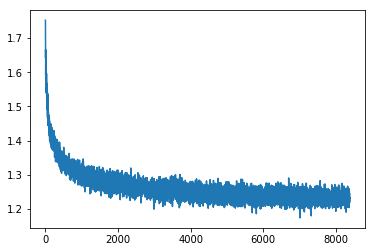

##### Smoothed Training Loss Curve

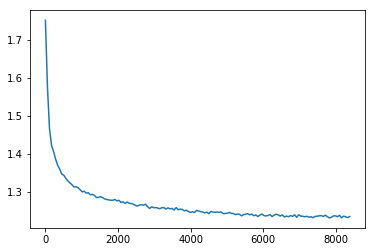

##### Smoothed and Zoomed Training Loss Curve

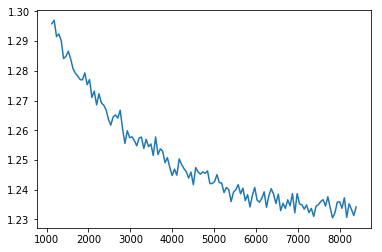

#### Test Error

* s0 Baseline Loss: 1776.58

* s0 Oracle Loss: 163.92

* s0 Model Loss: 698.22

* s1 Baseline Loss: 1538.31

* s1 Oracle Loss: 67.37

* s1 Model Loss: 360.66

* s2 Baseline Loss: 1399.45

* s2 Oracle Loss: 36.53

* s2 Model Loss: 242.09

## Experiment Summary: rnn2_cat_layr3

<class 'numpy.ndarray'>
<class 'int'>
<class 'int'>
[605.19866895 327.35503763 252.12924658]
[163.91688661  67.3719056   36.5273668 ]
[1776.58367751 1538.30880254 1399.44951528]


#### Training Curves

##### Raw Training Loss Curve

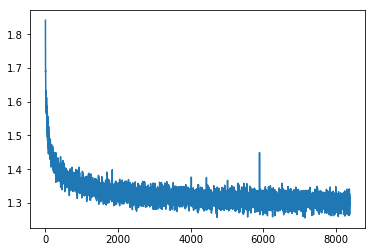

##### Smoothed Training Loss Curve

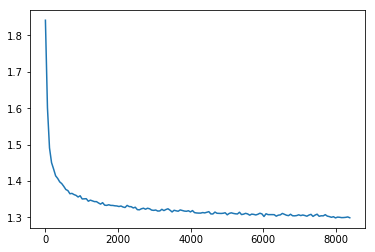

##### Smoothed and Zoomed Training Loss Curve

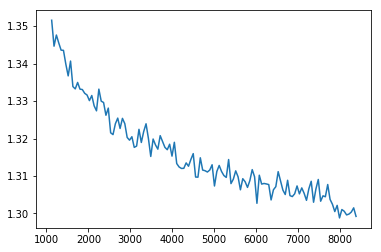

#### Test Error

* s0 Baseline Loss: 1776.58

* s0 Oracle Loss: 163.92

* s0 Model Loss: 605.20

* s1 Baseline Loss: 1538.31

* s1 Oracle Loss: 67.37

* s1 Model Loss: 327.36

* s2 Baseline Loss: 1399.45

* s2 Oracle Loss: 36.53

* s2 Model Loss: 252.13

## Experiment Summary: rnn2_cat_layr2_hidn75

<class 'numpy.ndarray'>
<class 'int'>
<class 'int'>
[606.64145924 307.78042572 217.73448512]
[163.91688661  67.3719056   36.5273668 ]
[1776.58367751 1538.30880254 1399.44951528]


#### Training Curves

##### Raw Training Loss Curve

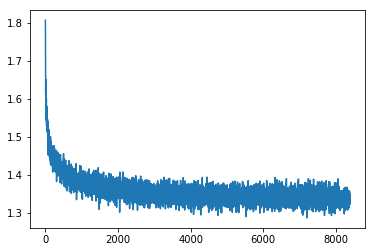

##### Smoothed Training Loss Curve

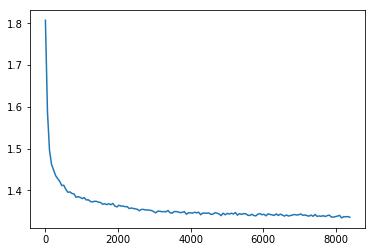

##### Smoothed and Zoomed Training Loss Curve

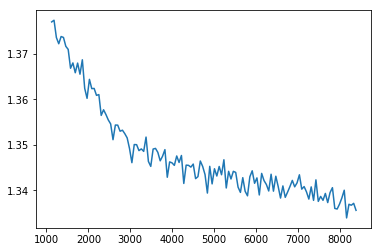

#### Test Error

* s0 Baseline Loss: 1776.58

* s0 Oracle Loss: 163.92

* s0 Model Loss: 606.64

* s1 Baseline Loss: 1538.31

* s1 Oracle Loss: 67.37

* s1 Model Loss: 307.78

* s2 Baseline Loss: 1399.45

* s2 Oracle Loss: 36.53

* s2 Model Loss: 217.73

## Experiment Summary: rnn2_cat_layr2_zeros

<class 'numpy.ndarray'>
<class 'int'>
<class 'int'>
[568.07579856 297.17937768 226.79211772]
[163.91688661  67.3719056   36.5273668 ]
[1776.58367751 1538.30880254 1399.44951528]


#### Training Curves

##### Raw Training Loss Curve

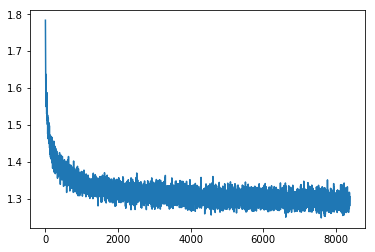

##### Smoothed Training Loss Curve

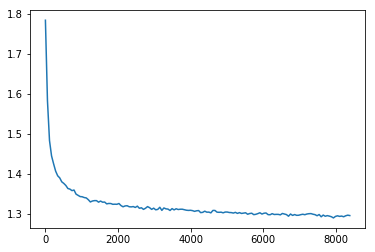

##### Smoothed and Zoomed Training Loss Curve

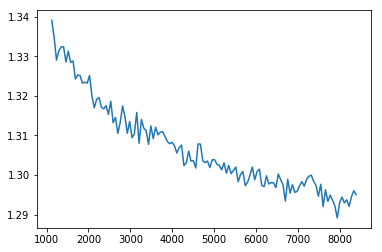

#### Test Error

* s0 Baseline Loss: 1776.58

* s0 Oracle Loss: 163.92

* s0 Model Loss: 568.08

* s1 Baseline Loss: 1538.31

* s1 Oracle Loss: 67.37

* s1 Model Loss: 297.18

* s2 Baseline Loss: 1399.45

* s2 Oracle Loss: 36.53

* s2 Model Loss: 226.79

## Experiment Summary: rnn2_cat_layr2

<class 'numpy.ndarray'>
<class 'int'>
<class 'int'>
[572.5316441  304.19018478 212.21120976]
[163.91688661  67.3719056   36.5273668 ]
[1776.58367751 1538.30880254 1399.44951528]


#### Training Curves

##### Raw Training Loss Curve

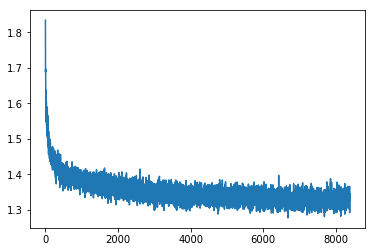

##### Smoothed Training Loss Curve

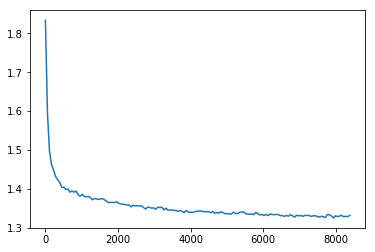

##### Smoothed and Zoomed Training Loss Curve

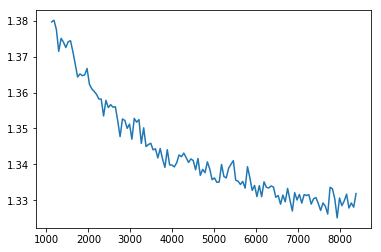

#### Test Error

* s0 Baseline Loss: 1776.58

* s0 Oracle Loss: 163.92

* s0 Model Loss: 572.53

* s1 Baseline Loss: 1538.31

* s1 Oracle Loss: 67.37

* s1 Model Loss: 304.19

* s2 Baseline Loss: 1399.45

* s2 Oracle Loss: 36.53

* s2 Model Loss: 212.21

## Experiment Summary: rnn2_cat

<class 'numpy.ndarray'>
<class 'int'>
<class 'int'>
[658.79956832 346.06397555 283.30560874]
[163.91688661  67.3719056   36.5273668 ]
[1776.58367751 1538.30880254 1399.44951528]


#### Training Curves

##### Raw Training Loss Curve

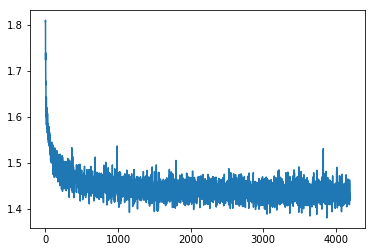

##### Smoothed Training Loss Curve

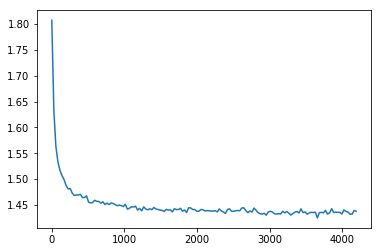

##### Smoothed and Zoomed Training Loss Curve

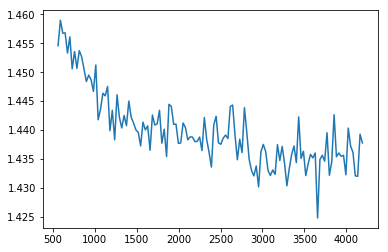

#### Test Error

* s0 Baseline Loss: 1776.58

* s0 Oracle Loss: 163.92

* s0 Model Loss: 658.80

* s1 Baseline Loss: 1538.31

* s1 Oracle Loss: 67.37

* s1 Model Loss: 346.06

* s2 Baseline Loss: 1399.45

* s2 Oracle Loss: 36.53

* s2 Model Loss: 283.31

## Experiment Summary: rnn2_simp_layr3_zeros

<class 'numpy.ndarray'>
<class 'int'>
<class 'int'>
[579.5715956  213.90340175 265.91328362 171.11096214 202.28764122]
[163.91688661 584.05827986  67.3719056  708.30332667  36.5273668 ]
[1776.58367751 1110.81048358 1538.30880254  908.02709715 1399.44951528]


#### Training Curves

##### Raw Training Loss Curve

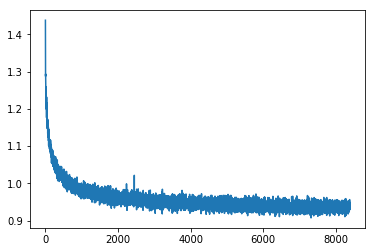

##### Smoothed Training Loss Curve

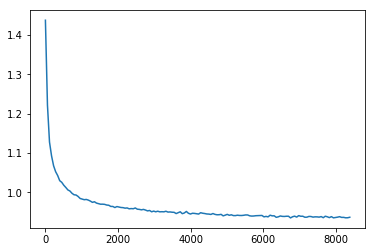

##### Smoothed and Zoomed Training Loss Curve

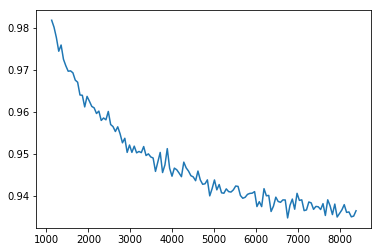

#### Test Error

* s0 Baseline Loss: 1776.58

* s0 Oracle Loss: 163.92

* s0 Model Loss: 579.57

* s1 Baseline Loss: 1538.31

* s1 Oracle Loss: 67.37

* s1 Model Loss: 265.91

* s2 Baseline Loss: 1399.45

* s2 Oracle Loss: 36.53

* s2 Model Loss: 202.29

## Experiment Summary: rnn2_simp_layr3

<class 'numpy.ndarray'>
<class 'int'>
<class 'int'>
[852.67683482 200.79579292 352.95878537 155.73514983 295.8656556 ]
[163.91688661 584.05827986  67.3719056  708.30332667  36.5273668 ]
[1776.58367751 1110.81048358 1538.30880254  908.02709715 1399.44951528]


#### Training Curves

##### Raw Training Loss Curve

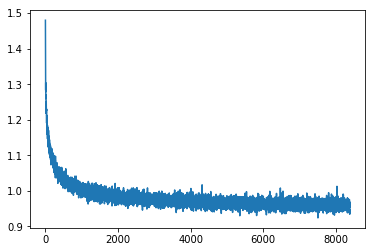

##### Smoothed Training Loss Curve

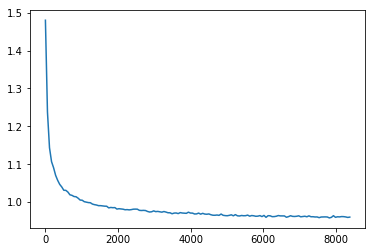

##### Smoothed and Zoomed Training Loss Curve

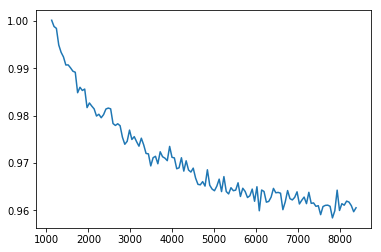

#### Test Error

* s0 Baseline Loss: 1776.58

* s0 Oracle Loss: 163.92

* s0 Model Loss: 852.68

* s1 Baseline Loss: 1538.31

* s1 Oracle Loss: 67.37

* s1 Model Loss: 352.96

* s2 Baseline Loss: 1399.45

* s2 Oracle Loss: 36.53

* s2 Model Loss: 295.87

model|s0|s1|s2
---|---|---|---
oracle|163.9168866141811|67.37190560137539|36.527366796446515
baseline|1776.583677509689|1538.3088025431973|1399.4495152775526
rnn2_cat_layr3_zeros|698.2159784063552|360.65571565618484|242.0942948632374
rnn2_cat_layr3|605.1986689493692|327.3550376330427|252.12924657733248
rnn2_cat_layr2_hidn75|606.6414592419686|307.7804257164259|217.73448512084732
rnn2_cat_layr2_zeros|568.0757985593118|297.1793776771402|226.79211771542094
rnn2_cat_layr2|572.5316440966358|304.1901847841224|212.21120975906837
rnn2_cat|658.7995683190929|346.06397555161317|283.3056087407039
rnn2_simp_layr3_zeros|579.5715955963132|265.91328361608396|202.28764121886707
rnn2_simp_layr3|852.6768348246923|352.9587853746175|295.86565560252825


In [61]:
main()